In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import xgboost as xgb
from scipy.stats import pearsonr, bartlett, levene, wilcoxon, mannwhitneyu, ttest_ind, f_oneway, kruskal
from scipy.stats import shapiro, anderson, kstest, normaltest, jarque_bera
import pingouin as pg
import scikit_posthocs as sp
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

In [2]:
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

In [3]:
df = pd.read_csv('C:/Users/Home/Desktop/Data/2차/CardData_new.csv', encoding = 'cp949')

In [4]:
df2 = df.copy()

In [5]:
d = {
    '21.Active_연속' : 0,
    '22.Active_간헐' : 1,
    '34.휴면_9M+' : 2,
    '32.휴면_6M-' : 2,
    '33.휴면_9M-' : 2,
    '31.휴면_3M' : 2
}
df2['고객구분'] = df2['고객구분'].map(d)

In [6]:
df2['Recency'] = (df[['이용후경과월_신용','이용후경과월_체크', '이용후경과월_카드론']]).min(axis= 1)

In [7]:
df2['Frequency'] = df2['이용건수_신용_R12M'] + df2['이용건수_체크_R12M'] + df2['이용건수_카드론_R12M']

In [8]:
df2['Monetary'] = df2['이용금액_신용_R12M'] + df2['이용금액_체크_R12M'] + df2['이용금액_카드론_R12M'] + df2['이용금액_업종기준']

# RFM 8개 값 분류

In [9]:
scaler = MinMaxScaler()
df2['Recency_s'] = scaler.fit_transform(df2[['Recency']])
df2['Frequency_s'] = scaler.fit_transform(df2[['Frequency']])
df2['Monetary_s'] = scaler.fit_transform(df2[['Monetary']])

C:\Users\Home\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Home\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Home\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Home\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

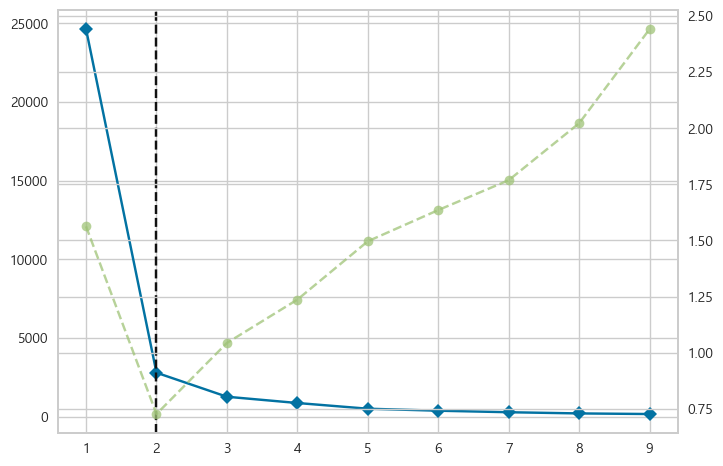

In [10]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(df2[['Recency_s','Frequency_s','Monetary_s']])
# k = 2

In [11]:
# KMeans 모델 생성 (k=2)
kmeans = KMeans(n_clusters=2)
# 모델 학습 및 예측
labels = kmeans.fit_predict(df2[['Recency_s','Frequency_s','Monetary_s']])

C:\Users\Home\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
df2['labels_k'] = labels

In [13]:
df2.groupby('labels_k')[['Recency_s', 'Frequency_s', 'Monetary_s']].agg('mean')

,Recency_s,Frequency_s,Monetary_s
labels_k,,,
0,0.018153,0.045819,0.002663
1,0.887180,0.004693,0.001014


In [14]:
# CV = k개 그룹에 대한 각 R,F,M의 표준편차 / 평균
cv_k = df2.groupby('labels_k')[['Recency_s', 'Frequency_s', 'Monetary_s']].agg('std')/df2.groupby('labels_k')[['Recency_s', 'Frequency_s', 'Monetary_s']].agg('mean')
cv_k

,Recency_s,Frequency_s,Monetary_s
labels_k,,,
0,3.707733,1.040649,1.242323
1,0.195777,1.055173,0.395543


In [15]:
CV = cv_k.sum()
CV

Recency_s      3.903510
Frequency_s    2.095822
Monetary_s     1.637866
dtype: float64

In [16]:
res2 = cv_k.min(axis = 0) / CV
res2

Recency_s      0.050154
Frequency_s    0.496535
Monetary_s     0.241499
dtype: float64

In [17]:
# 가중치
w1, w2, w3 = (res2 / res2.sum())
print(w1, w2, w3)

0.0636321049561043 0.629970431576547 0.30639746346734875


In [18]:
import itertools
val = [243637,   8549,   5339,   4252,   3121,   2768,   2468,   2273, 1903,   1721,   1644,   1539,  20786]
res = []

for case in filter(lambda x : sum(x) == 13, itertools.product(range(1, 7), repeat = 8)):
    res.append((case, pd.Series([sum(val[:case[0]]), sum(val[case[0]:sum(case[:1])]), sum(val[sum(case[:1]):sum(case[:2])]), sum(val[sum(case[:2]):sum(case[:3])]), sum(val[sum(case[:3]):sum(case[:4])]), sum(val[sum(case[:4]):sum(case[:5])]), sum(val[sum(case[:5]):sum(case[:6])]), sum(val[sum(case[:6]):])]).std()))

sorted(res, key = lambda x : x[1])[:10]

[((1, 1, 1, 2, 3, 3, 1, 1), 83535.69104623143),
 ((1, 1, 1, 2, 2, 4, 1, 1), 83535.81543437351),
 ((1, 1, 1, 1, 3, 4, 1, 1), 83541.06718939409),
 ((1, 1, 2, 2, 2, 3, 1, 1), 83544.15026285716),
 ((1, 1, 1, 1, 2, 5, 1, 1), 83548.03889465543),
 ((1, 1, 1, 3, 2, 3, 1, 1), 83548.14907926702),
 ((1, 1, 2, 2, 3, 2, 1, 1), 83548.62772062747),
 ((1, 1, 1, 2, 4, 2, 1, 1), 83549.17612144016),
 ((1, 1, 2, 1, 3, 3, 1, 1), 83551.8176445868),
 ((1, 1, 2, 1, 2, 4, 1, 1), 83551.94200872038)]

In [19]:
df2['Recency_8'] = df2['Recency'].map(lambda x : dict(zip(range(13), [8, 7, 6, 5, 5, 4, 4, 4, 3, 3, 3, 2, 1]))[x])

In [20]:
df2['Frequency_8'] = pd.cut(df2['Frequency'], bins = [df2['Frequency'].quantile(0), df2['Frequency'].quantile(0.125), df2['Frequency'].quantile(0.25), df2['Frequency'].quantile(0.375), df2['Frequency'].quantile(0.5), df2['Frequency'].quantile(0.625), df2['Frequency'].quantile(0.75), df2['Frequency'].quantile(0.875), df2['Frequency'].quantile(1)], labels = range(1, 9), include_lowest = True).astype(np.int64)

In [21]:
df2['Monetary_8'] = pd.cut(df2['Monetary'], bins = [df2['Monetary'].quantile(0), df2['Monetary'].quantile(0.125), df2['Monetary'].quantile(0.25), df2['Monetary'].quantile(0.375), df2['Monetary'].quantile(0.5), df2['Monetary'].quantile(0.625), df2['Monetary'].quantile(0.75), df2['Monetary'].quantile(0.875), df2['Monetary'].quantile(1)], labels = range(1, 9), include_lowest = True).astype(np.int64)

In [25]:
df2['RFM_Score'] = ((w1 * df2['Recency_8'] + w2 * df2['Frequency_8'] + w3 * df2['Monetary_8']) / 8) * 100

In [26]:
df2['RFM_Class'] = pd.cut(df2['RFM_Score'], bins = [df2['RFM_Score'].quantile(0), df2['RFM_Score'].quantile(0.125), df2['RFM_Score'].quantile(0.25), df2['RFM_Score'].quantile(0.375), df2['RFM_Score'].quantile(0.5), df2['RFM_Score'].quantile(0.625), df2['RFM_Score'].quantile(0.75), df2['RFM_Score'].quantile(0.875), df2['RFM_Score'].quantile(1)], labels = ['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객'], include_lowest = True).astype(np.dtype('O'))
df2['RFM_Class'].value_counts()

이탈우려고객     44743
잠재VIP고객    41408
겨울잠고객      37522
잠재충성고객     37134
관심필요고객     37092
충성고객       35958
VIP고객      33888
놓치면안될고객    32255
Name: RFM_Class, dtype: int64

In [28]:
for rfm, customer_group in sorted(df2.groupby(by = ['RFM_Class'])[['고객구분']], key = lambda x : dict(zip(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객'], range(8, 0, -1)))[x[0]]):
    print(rfm)
    print(customer_group['고객구분'].value_counts())
    print()

VIP고객
0    33121
1      540
2      227
Name: 고객구분, dtype: int64

충성고객
0    34469
1     1038
2      451
Name: 고객구분, dtype: int64

잠재VIP고객
0    38619
1     1805
2      984
Name: 고객구분, dtype: int64

잠재충성고객
0    33689
1     2129
2     1316
Name: 고객구분, dtype: int64

놓치면안될고객
0    26534
1     3544
2     2177
Name: 고객구분, dtype: int64

관심필요고객
0    26307
1     6563
2     4222
Name: 고객구분, dtype: int64

이탈우려고객
0    28217
1     9055
2     7471
Name: 고객구분, dtype: int64

겨울잠고객
2    31254
1     4361
0     1907
Name: 고객구분, dtype: int64



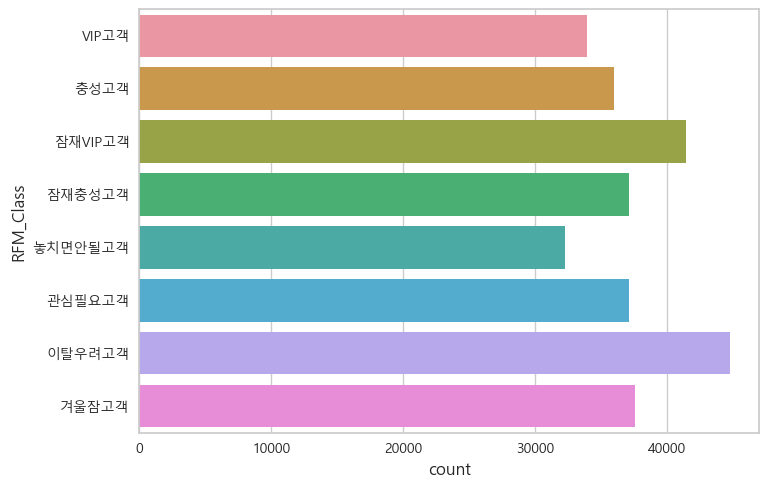

In [29]:
sns.countplot(y = 'RFM_Class', data = df2, orient = 'h', order = reversed(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객', '잠재충성고객','잠재VIP고객','충성고객','VIP고객']))
plt.show()

In [35]:
# RFM_Class 그룹에 따른 R, F, M들의 평균값/중위값 차이가 있는지 분산분석
for column in ['Recency', 'Frequency', 'Monetary']:
  normally = []
  for cla in df2['RFM_Class'].unique():
    # 1. 정규성 검정
    # shapiro나 kolmogorov-smirnov 같은 검정방법은 데이터의 갯수에 따라 달라지므로 데이터 갯수에 상관없이 하기 위해 normaltest로 검정
    cla_tv, cla_pv = normaltest(df2.loc[df2['RFM_Class'] == cla, column])
    if cla_pv >= 0.05:
      normally.append(True)
    else:
      normally.append(False)

  # 정규성인지 아닌지에 따라 등분산분석 할지 정하기
  if all(normally):
    # 2. 등분산분석
    bartlett_tv, bartlett_pv = bartlett(*[df2.loc[df2['RFM_Class'] == cla, column] for cla in df2['RFM_Class'].unique()])
    # 등분산이므로 F검정으로 일원분산분석
    if bartlett_pv >= 0.05:
      f_oneway_tv, f_oneway_pv = f_oneway(*[df2.loc[df2['RFM_Class'] == cla, column] for cla in df2['RFM_Class'].unique()])
      if f_oneway_pv < 0.05:
        print(f'column : {column},     f_oneway : {f_oneway_pv}')
    # 등분산이 아니므로 Welch_Anova로 일원분산분석
    else:
      welch_anova_tv, welch_anova_pv = pg.welch_anova(dv = column, between = 'RFM_Class', data = df2)
      if welch_anova_pv < 0.05:
        print(f'column : {column},     welch_anova_pv : {welch_anova_pv}')
  # 정규성을 만족하지 않으므로 Kruskal-Wallis H-test로 일원분산분석
  else:
    kruskal_tv, kruskal_pv = kruskal(*[df2.loc[df2['RFM_Class'] == cla, column] for cla in df2['RFM_Class'].unique()])
    if kruskal_pv < 0.05:
      print(f'column : {column},     kruskal_pv : {kruskal_pv}')

column : Recency,     kruskal_pv : 0.0
column : Frequency,     kruskal_pv : 0.0
column : Monetary,     kruskal_pv : 0.0


In [36]:
df2.groupby(by = ['RFM_Class'])[['Recency', 'Frequency', 'Monetary']].agg('median').sort_index(key = lambda x : x.map(lambda y : dict(zip(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객'], range(8, 0, -1)))[y]))

,Recency,Frequency,Monetary
RFM_Class,,,
VIP고객,0.0,832.0,24057959.0
충성고객,0.0,459.0,18081942.5
잠재VIP고객,0.0,296.0,10628446.0
잠재충성고객,0.0,186.0,6953471.0
놓치면안될고객,0.0,105.0,6323250.0
관심필요고객,0.0,56.0,2930139.5
이탈우려고객,0.0,17.0,640360.0
겨울잠고객,12.0,0.0,0.0


# 모델링

## 로지스틱

In [37]:
df3 = df2[df2['고객구분'] != 1.0]

In [38]:
df3['고객구분'].value_counts()

0    222863
2     48102
Name: 고객구분, dtype: int64

In [39]:
# 데이터 준비 (X는 특성 데이터, y는 타겟 변수)
X = df3[['Recency_s', 'Frequency_s', 'Monetary_s']]
y = df3['고객구분']  # Target 컬럼에 이탈 여부 정보가 있는 것으로 가정

# 데이터 분할 (학습 데이터와 테스트 데이터로 나누기)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 생성
logreg_model = LogisticRegression()

# 모델 학습
logreg_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = logreg_model.predict(X_test)

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9808831398889155
Confusion Matrix:
 [[44506     0]
 [ 1036  8651]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     44506
           2       1.00      0.89      0.94      9687

    accuracy                           0.98     54193
   macro avg       0.99      0.95      0.97     54193
weighted avg       0.98      0.98      0.98     54193



In [40]:
df4 = df2[df2['고객구분'] == 1.0]

In [41]:
df4 = df4[['Recency_s', 'Frequency_s', 'Monetary_s','RFM_Class']]

In [42]:
X1 = df4[['Recency_s', 'Frequency_s', 'Monetary_s']]

In [43]:
df4['first_step_prediction'] = logreg_model.predict(X1)

In [44]:
df4['first_step_prediction'].value_counts()

0    24306
2     4729
Name: first_step_prediction, dtype: int64

In [45]:
df4.loc[df4['RFM_Class'] == 'VIP고객','first_step_prediction'].value_counts()

0    510
2     30
Name: first_step_prediction, dtype: int64

In [46]:
df4.loc[df4['RFM_Class'] == '충성고객','first_step_prediction'].value_counts()

0    917
2    121
Name: first_step_prediction, dtype: int64

In [47]:
df4.loc[df4['RFM_Class'] == '잠재VIP고객','first_step_prediction'].value_counts()

0    1594
2     211
Name: first_step_prediction, dtype: int64

In [48]:
df4.loc[df4['RFM_Class'] == '잠재충성고객','first_step_prediction'].value_counts()

0    1895
2     234
Name: first_step_prediction, dtype: int64

In [49]:
df4.loc[df4['RFM_Class'] == '놓치면안될고객','first_step_prediction'].value_counts()

0    3008
2     536
Name: first_step_prediction, dtype: int64

In [50]:
df4.loc[df4['RFM_Class'] == '관심필요고객','first_step_prediction'].value_counts()

0    5570
2     993
Name: first_step_prediction, dtype: int64

In [51]:
df4.loc[df4['RFM_Class'] == '이탈우려고객','first_step_prediction'].value_counts()

0    7542
2    1513
Name: first_step_prediction, dtype: int64

In [52]:
df4.loc[df4['RFM_Class'] == '겨울잠고객','first_step_prediction'].value_counts()

0    3270
2    1091
Name: first_step_prediction, dtype: int64

## 랜덤포레스트

In [53]:
# 데이터 준비 (X는 특성 데이터, y는 타겟 변수)
X = df3[['Recency_s', 'Frequency_s', 'Monetary_s']]
y = df3['고객구분']  # Target 컬럼에 이탈 여부 정보가 있는 것으로 가정

# 데이터 분할 (학습 데이터와 테스트 데이터로 나누기)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 생성
RF_model = RandomForestClassifier()

# 모델 학습
RF_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = RF_model.predict(X_test)

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9813075489454357
Confusion Matrix:
 [[44339   167]
 [  846  8841]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     44506
           2       0.98      0.91      0.95      9687

    accuracy                           0.98     54193
   macro avg       0.98      0.95      0.97     54193
weighted avg       0.98      0.98      0.98     54193



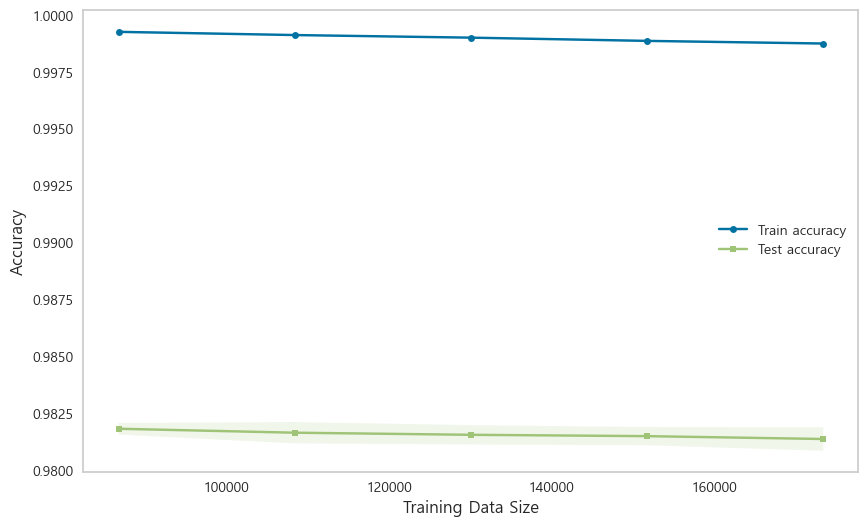

In [54]:
from sklearn.model_selection import learning_curve

# 학습 데이터 크기 설정
train_sizes = [0.4, 0.5, 0.6, 0.7, 0.8]

# Learning Curve 계산
train_sizes, train_scores, test_scores = learning_curve(
    RF_model,  # 모델
    X,  # 특성 행렬
    y,  # 타겟 벡터
    train_sizes=train_sizes,  # 학습 데이터 크기 설정
    cv=5,  # 교차 검증 횟수 (폴드 수)
    scoring='accuracy'  # 성능 지표 설정 (정확도 등)
)

# 성능 평균 및 표준편차 계산
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Learning Curve 그리기
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Train accuracy', marker='o', markersize=5)
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15)
plt.plot(train_sizes, test_mean, label='Test accuracy', marker='s', markersize=5)
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15)
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [88]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# K-Fold 교차 검증을 위한 K 값 설정
k = 5  # 5개의 폴드로 나누어 검증
X = df3[['Recency_s', 'Frequency_s', 'Monetary_s']]
y = df3['고객구분']  # Target 컬럼에 이탈 여부 정보가 있는 것으로 가정
# 모델 생성 (여기서는 RandomForestClassifier를 예시로 사용)
RF_model = RandomForestClassifier()

# K-Fold 교차 검증 수행
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# K-Fold 교차 검증 결과를 담을 리스트
results = []

k_num =0

# K번의 학습과 검증을 반복
for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    k_num += 1

    # 모델 학습
    RF_model.fit(X_train, y_train)

    # 모델 평가 (여기서는 accuracy를 평가 지표로 사용)
    score = RF_model.score(X_test, y_test)

    # 결과 저장
    results.append(score)

    # K-Fold 교차 검증 결과 출력
    print(f"{k_num}번째 K-Fold 결과:", results[-1])\

# K-Fold 교차 검증 결과 평균 출력
print("Average Accuracy:", sum(results) / k)

1번째 K-Fold 결과: 0.982082556787777
2번째 K-Fold 결과: 0.9805325411030945
3번째 K-Fold 결과: 0.981196833539387
4번째 K-Fold 결과: 0.9817873157049803
5번째 K-Fold 결과: 0.9815843374605576
Average Accuracy: 0.9814367169191593


In [57]:
# k=5로 k-fold cross validation 수행
scores = cross_val_score(RF_model, X, y, cv=5)
print("교차 검증 점수: ", scores)

교차 검증 점수:  [0.9812891  0.98182422 0.98149207 0.98138136 0.98210101]


In [58]:
df4 = df2[df2['고객구분'] == 1.0]

In [59]:
df4 = df4[['Recency_s', 'Frequency_s', 'Monetary_s','RFM_Class']]

In [60]:
X1 = df4[['Recency_s', 'Frequency_s', 'Monetary_s']]

In [61]:
df4['first_step_prediction'] = RF_model.predict(X1)

In [62]:
df4['first_step_prediction'].value_counts()

0    14950
2    14085
Name: first_step_prediction, dtype: int64

In [63]:
df4.loc[df4['RFM_Class'] == 'VIP고객','first_step_prediction'].value_counts()

0    443
2     97
Name: first_step_prediction, dtype: int64

In [64]:
df4.loc[df4['RFM_Class'] == '충성고객','first_step_prediction'].value_counts()

0    684
2    354
Name: first_step_prediction, dtype: int64

In [65]:
df4.loc[df4['RFM_Class'] == '잠재VIP고객','first_step_prediction'].value_counts()

0    1157
2     648
Name: first_step_prediction, dtype: int64

In [66]:
df4.loc[df4['RFM_Class'] == '잠재충성고객','first_step_prediction'].value_counts()

0    1438
2     691
Name: first_step_prediction, dtype: int64

In [67]:
df4.loc[df4['RFM_Class'] == '놓치면안될고객','first_step_prediction'].value_counts()

0    1874
2    1670
Name: first_step_prediction, dtype: int64

In [68]:
df4.loc[df4['RFM_Class'] == '관심필요고객','first_step_prediction'].value_counts()

0    3655
2    2908
Name: first_step_prediction, dtype: int64

In [69]:
df4.loc[df4['RFM_Class'] == '이탈우려고객','first_step_prediction'].value_counts()

0    4864
2    4191
Name: first_step_prediction, dtype: int64

In [70]:
df4.loc[df4['RFM_Class'] == '겨울잠고객','first_step_prediction'].value_counts()

2    3526
0     835
Name: first_step_prediction, dtype: int64

## XGBoost

In [71]:
df3['고객구분_xgb'] = df2['고객구분'].replace({2: 1})

C:\Users\Home\AppData\Local\Temp\ipykernel_25348\3585182153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['고객구분_xgb'] = df2['고객구분'].replace({2: 1})


In [72]:
df3['고객구분_xgb'].value_counts()

0    222863
1     48102
Name: 고객구분_xgb, dtype: int64

In [73]:
# 데이터 준비 (X는 특성 데이터, y는 타겟 변수)
X = df3[['Recency_s', 'Frequency_s', 'Monetary_s']]
y = df3['고객구분_xgb']  # Target 컬럼에 이탈 여부 정보가 있는 것으로 가정

#데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 분류 모델 생성
xgb_model = xgb.XGBClassifier()

# 모델 학습
xgb_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = xgb_model.predict(X_test)

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9841492443673537
Confusion Matrix:
 [[44499     7]
 [  852  8835]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     44506
           1       1.00      0.91      0.95      9687

    accuracy                           0.98     54193
   macro avg       0.99      0.96      0.97     54193
weighted avg       0.98      0.98      0.98     54193



In [74]:
# 학습 데이터로 예측
y_pred_train = xgb_model.predict(X_train)

# 성능 평가
accuracy = accuracy_score(y_train, y_pred_train)
conf_matrix = confusion_matrix(y_train, y_pred_train)
classification_rep = classification_report(y_train, y_pred_train)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9847996973778901
Confusion Matrix:
 [[178342     15]
 [  3280  35135]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    178357
           1       1.00      0.91      0.96     38415

    accuracy                           0.98    216772
   macro avg       0.99      0.96      0.97    216772
weighted avg       0.99      0.98      0.98    216772



In [75]:
df4 = df2[df2['고객구분'] == 1.0]

In [76]:
df4 = df4[['Recency_s', 'Frequency_s', 'Monetary_s','RFM_Class']]

In [77]:
X1 = df4[['Recency_s', 'Frequency_s', 'Monetary_s']]

df4['first_step_prediction'] = logreg_model.predict(X1)

df4['first_step_prediction'].value_counts()

0    24306
2     4729
Name: first_step_prediction, dtype: int64

In [78]:
df4.loc[df4['RFM_Class'] == 'VIP고객','first_step_prediction'].value_counts()

0    510
2     30
Name: first_step_prediction, dtype: int64

In [79]:
df4.loc[df4['RFM_Class'] == '충성고객','first_step_prediction'].value_counts()

0    917
2    121
Name: first_step_prediction, dtype: int64

In [80]:
df4.loc[df4['RFM_Class'] == '잠재VIP고객','first_step_prediction'].value_counts()

0    1594
2     211
Name: first_step_prediction, dtype: int64

In [81]:
df4.loc[df4['RFM_Class'] == '잠재충성고객','first_step_prediction'].value_counts()

0    1895
2     234
Name: first_step_prediction, dtype: int64

In [82]:
df4.loc[df4['RFM_Class'] == '놓치면안될고객','first_step_prediction'].value_counts()

0    3008
2     536
Name: first_step_prediction, dtype: int64

In [83]:
df4.loc[df4['RFM_Class'] == '관심필요고객','first_step_prediction'].value_counts()

0    5570
2     993
Name: first_step_prediction, dtype: int64

In [84]:
df4.loc[df4['RFM_Class'] == '이탈우려고객','first_step_prediction'].value_counts()

0    7542
2    1513
Name: first_step_prediction, dtype: int64

In [85]:
df4.loc[df4['RFM_Class'] == '겨울잠고객','first_step_prediction'].value_counts()

0    3270
2    1091
Name: first_step_prediction, dtype: int64